<a href="https://colab.research.google.com/github/Amirh9775/cap-comp215/blob/main/Project1_Comp215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comp 215, Amir Hemmat

Project: Game of life

In [2]:
import json, requests
import matplotlib.pyplot as plt
from pprint import pprint
import os
import re
from genericpath import exists
from scipy.signal import correlate2d

In [3]:
%matplotlib inline

import os
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

from utils import underride


--2022-03-14 18:37:06--  https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.58K  --.-KB/s    in 0s      

2022-03-14 18:37:06 (35.4 MB/s) - ‘utils.py’ saved [2645/2645]

--2022-03-14 18:37:06--  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2628 (2.6K) [text/plain]


Read file:  https://conwaylife.com/patterns

In [4]:
PATTERN_SITE = 'https://conwaylife.com/patterns'
PATTERNS = ('glider','lwss', 'mwss', 'hwss', '3-engine Cordership gun')

FOLDER = 'patterns'
if not os.path.exists(FOLDER):
  os.mkdir(FOLDER)

def getPatternFile(patternName):
  """ Loads the RLE file for the given pattern name from the PATTERN_SITE"""
  patternFile = '{name}.rle'.format(name = patternName)
  url = os.path.join(PATTERN_SITE, patternFile)
  response = requests.request("GET", url, headers={}, data={})
  with open(os.path.join(FOLDER, patternFile), 'w') as outfile:
    outfile.write(response.text)
  return patternFile

pattern_files = {
    pattern : getPatternFile(pattern) for pattern in PATTERNS
}

### Copied From Graham's Code

In [5]:
def extract_RLE_string(name):
  """
  Retrives the rle format string for the initial cell states of desired pattern
  """

  with open(('/content/patterns/{name}.rle').format(name=name), 'r') as file:
    num_lines = sum(1 for line in file)
    if num_lines <= 6:
     file.seek(0, 0)
     pattern = file.readlines()[-1]
     return pattern
    else:
      print('error, file too long') #TODO add long file case
    return

extract_RLE_string('glider')

def RLE_to_add_cells(name):
  """
  read the input string and convert in to an np.array kernal to overlay into initail cell2D state
  """
  RLE_string = makeStrTrueLen(extract_RLE_string(name))
  RLE_string = RLE_string.replace('b', '0')
  RLE_string= RLE_string.replace('o', '1')
  RLE_string= RLE_string.replace('!', '')

  
  strParts = RLE_string.split('$')
  if len(strParts[0]) != len(strParts[-1]):
    strParts[-1] += '0'
  #print(strParts)
  #for i, s in enumerate(strParts):
    #print(i,s)
  return strParts
    
  """
  # removed to simplify usage with Cell2D object, returns list of strings to use
  #with Cell2D.add_cells method

  array = np.zeros((len(strParts), len(strParts[0])), np.uint8)
 
  for i, s in enumerate(strParts):
    array[i] = [int(c) for c in s]
    print(s)
  print(array)
  """
#format retrieved string to remove digit stored repeated values
def makeStrTrueLen(s):
  s_list = list(s)
  #get index location of ints in s_list, store in num_location --DONE--
  numLocation = []
  for i in range(len(s_list)):
    if str(s_list[i]).isdigit() == True:
      numLocation.append(i)
  
  #read through num location, take value of int, char in s_list n+1 and 
  #replace the int in num location with (int-1)*char of n+1 
  counter = 0
  for counter in range(len(numLocation)):
    index = numLocation[counter]
    multiplyer = s_list[index]
    s_list[index] = s_list[index + 1] * (int(multiplyer) - 1)

  trueLenRLE = ''.join(s_list)
  #print(trueLenRLE)

  return trueLenRLE


print(RLE_to_add_cells('glider'))
RLE_to_add_cells('lwss')

['010', '001', '111']


['01001', '10000', '10001', '11110']

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from utils import decorate
from scipy.signal import correlate2d
#from Cell2D import Cell2D



In [7]:
class Cell2D:
    """Parent class for 2-D cellular automata."""

    def __init__(self, n, m):
        """Initializes the attributes.
        n: number of rows
        m: number of columns
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)
        #self.colos=colos

    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.
        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def loop(self, iters=1):
        """Runs the given number of steps."""
        for i in range(iters):
            self.step()

    def draw(self,colos, **options):
        """Draws the array.
        """
        draw_array(self.array,colos, **options)

    def animate(self, frames, interval=None, step=None):
        """Animate the automaton.
        
        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """
        if step is None:
            step = self.step
            
        plt.figure()
        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass
        

def draw_array(array,colos, **options):
    """Draws the cells."""
    n, m = array.shape
    options = underride(options,
                        cmap=colos,
                        alpha=0.7,
                        vmin=0, vmax=1, 
                        interpolation='none', 
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    return plt.imshow(array, **options)

In [8]:


class Life(Cell2D):
    """Implementation of Conway's Game of Life."""
    kernel = np.array([[1, 1, 1],
                       [1,10, 1],
                       [1, 1, 1]])

    table = np.zeros(20, dtype=np.uint8)
    table[[3, 12, 13]] = 1

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array = self.table[c]

def make_life(n, m, row, col,colos, *strings):
    """Makes a Life object.
    
    n, m: rows and columns of the Life array
    row, col: upper left coordinate of the cells to be added
    strings: list of strings of '0' and '1'
    """
    life = Life(n, m)
    life.add_cells(row, col, *strings)
    return life



###Collision beetween two array 

In [9]:
def collision(a,b):
  for (i,j) in a:
    if a[i,j] == b[i,j]:
      a[i,j]=10
      b[i,j]=10
  return a,b

['010', '001', '111']
['01001', '10000', '10001', '11110']


TypeError: ignored

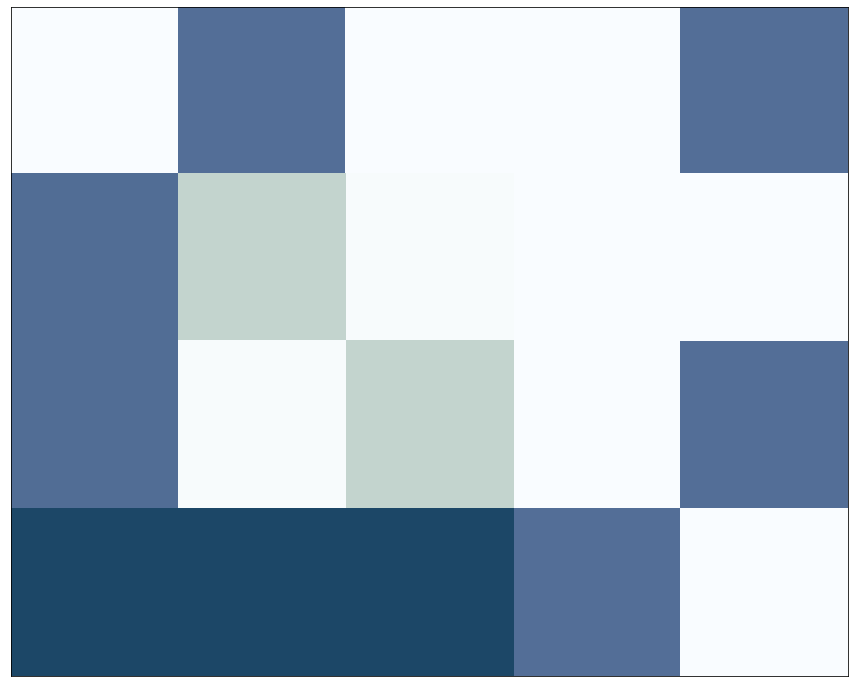

In [45]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 1 , 1)


print(b)

#for (i,j) in b:
  #print(i,j)


n=len(RLE_to_add_cells('glider'))
m=len(RLE_to_add_cells('glider')[0])
#print(n,m)
glider=RLE_to_add_cells('glider')
print(glider)
a=make_life(n,m,0,0,'Greens', *glider)
#type(RLE_to_add_cells('glider'))
#a
a.draw('Greens')
#a.step()
print(a)
lwss=RLE_to_add_cells('lwss')
print(lwss)
b=make_life(len(RLE_to_add_cells('lwss')),len(RLE_to_add_cells('lwss')[0]),0,0,'Blues', *lwss)
b.draw('Blues')
b[0]